In [ ]:
%matplotlib inline


Finetuning Deep Learning Models for Colorectal Disease Classification
=============================

**Author:** `Ala Salehi <https://github.com/ala-sk98>`




In this project we apply different deep learning models for colorectal disease classification (CDC) by finetuning and
feature extracting the [torchvision
models](https://pytorch.org/vision/stable/models.html), all of which have been pretrained on the 1000-class Imagenet dataset. 


This project will build an intuition for finetuning any PyTorch model and will give an indepth look the performance of different deep learning method on a pathology dataset. In this document we will perform two types of transfer learning:
finetuning and feature extraction. In **finetuning**, we start with a
pretrained model and update *all* of the model’s parameters for our new
task, in essence retraining the whole model. In **feature extraction**,
we start with a pretrained model and only update the final layer weights
from which we derive predictions. It is called feature extraction
because we use the pretrained CNN as a fixed feature-extractor, and only
change the output layer.

In general both transfer learning methods follow the same few steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step

Install latest version of Torch and Torch Vision
Now install PyTorch 1.7.0.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! git clone https://github.com/ala-sk98/RMSGD.git

fatal: destination path 'RMSGD' already exists and is not an empty directory.


In [ ]:
#! pip install RMSGD

In [ ]:
!pip install adamp

In [ ]:
! pip install torchmetrics


     |████████████████████████████████| 408 kB 4.9 MB/s 


In [ ]:
! pip install wandb
! wandb login

wandb: Currently logged in as: ala_sk (use `wandb login --relogin` to force relogin)


In [ ]:
##from rmsgd import RMSGD
#from adamp import AdamP

from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
#from torchmetrics import F1Score, Precision
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
import os
import copy
from PIL import Image
import matplotlib.cm as mpl_color_map
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from torch.autograd import Variable
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
#import wandb

#wandb.init(project="chaoyang-long-project", entity="ala_sk")

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


Inputs
------

We will use the [Chaoyang dataset](https://github.com/bupt-ai-cz/HSA-NRL). Chaoyang dataset contains 1111 normal, 842 serrated, 1404 adenocarcinoma, 664 adenoma, and 705 normal, 321 serrated, 840 adenocarcinoma, 273 adenoma samples for training and testing, respectively. Colon slides from Chaoyang hospital, the patch size is 512 × 512. Three professional pathologists labeled the patches. This dataset is available [by request](https://bupt-ai-cz.github.io/HSA-NRL/). In orginal dataset had train and test set and all labels were in json file. We convert it to three splits, train, validation and test.

::

   [resnet, convnext, alexnet, vgg, squeezenet, densenet, inception]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




In [ ]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "/content/drive/MyDrive/chaoyang-data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for 
num_epochs = 40

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

wandb.config = {
  "learning_rate": 0.001,
  "epochs": 40,
  "batch_size": 64
}

Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

Model Training and Validation Code
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model. The *is_inception* flag is used to accomodate the
*Inception v3* model, as that architecture uses an auxiliary output and
the overall model loss respects both the auxiliary output and the final
output, as described
`here <https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958>`__.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.




In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, is_inception=False):
    since = time.time()
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    f1 = F1Score(num_classes=4)
    precision = Precision(average='macro', num_classes=4)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            since1 = time.time()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                scheduler.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                #wandb.log({"roc": wandb.plot.roc_curve(labels, outputs)})


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            time_elapsed = time.time() - since1
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                wandb.log({"train_accuracy": epoch_acc})
                wandb.log({"train_loss": epoch_loss})



            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} complete in {:.0f}m {:.0f}s'.format(phase, time_elapsed // 60, time_elapsed % 60))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                val_acc = epoch_acc
                val_loss = epoch_loss
                wandb.log({"validation_accuracy": val_acc})
                wandb.log({"validation_loss": val_loss})
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    wandb.watch(model)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

Set Model Parameters’ .requires_grad attribute
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnext50_32x4d(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [ ]:
from torch.utils.data import dataset
from torchvision.transforms.transforms import RandomCrop
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        #transforms.CenterCrop(input_size),
        #transforms.FiveCrop(input_size),
        #transforms.RandomCrop(input_size),
        transforms.RandomRotation(90),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.6470, 0.5523, 0.6695], [0.1698, 0.1994, 0.1284])
    ]),
    'val': transforms.Compose([
        #transforms.RandomCrop(input_size),
        #transforms.CenterCrop(input_size),
        #transforms.FiveCrop(input_size),
        transforms.Resize(input_size),                         
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.6470, 0.5523, 0.6695], [0.1698, 0.1994, 0.1284])
    ]),
    'test': transforms.Compose([
        #transforms.RandomCrop(input_size),                      
        transforms.Resize(input_size),
        transforms.ToTensor(),
        #transforms.Normalize([0.6470, 0.5523, 0.6695], [0.6470, 0.5523, 0.6695])
    ]),    
}
print(data_transforms)
print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
'''
mean = 0.
std = 0.
loader1 = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=2)
loader2 = torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=2)
for images, _ in loader1:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

for images, _ in loader2:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= (len(loader1.dataset)+len(loader2.dataset))
std /= (len(loader1.dataset)+len(loader2.dataset))
print (mean, std)
'''

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.647, 0.5523, 0.6695], std=[0.1698, 0.1994, 0.1284])
), 'val': Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.647, 0.5523, 0.6695], std=[0.1698, 0.1994, 0.1284])
), 'test': Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)}
Initializing Datasets and Dataloaders...


Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft = RMSGD(params_to_update, lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer_ft = AdamP(params_to_update, lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-2)
scheduler_ft = torch.optim.lr_scheduler.CyclicLR(optimizer_ft, base_lr=0.0001, max_lr=0.001, cycle_momentum=False)

print('optimizer = AdamP(params_to_update, lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-2)')

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [ ]:
class_count = np.array([[1111, 842, 1404, 664], [352, 321, 420, 273]])
class_count_total = np.sum(class_count, axis=0)
class_sum = np.sum(class_count)
class_weights = np.array([1-(class_count_total[0]/class_sum), 1-(class_count_total[1]/class_sum), 1-(class_count_total[2]/class_sum), 1-(class_count_total[3]/class_sum)])
class_weights = class_weights.astype(np.float32)
class_weights = torch.from_numpy(class_weights)
class_weights = class_weights.to(device)
print(class_weights)

tensor([0.7284, 0.7841, 0.6614, 0.8261], device='cuda:0')


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Train and evaluate
model_ft, train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/39
----------
train Loss: 0.6417 Acc: 0.8483
train complete in 2m 21s
val Loss: 0.8394 Acc: 0.7870
val complete in 0m 19s

Epoch 1/39
----------


Comparison with Model Trained from Scratch
------------------------------------------

Just for fun, lets see how the model learns if we do not use transfer
learning. The performance of finetuning vs. feature extracting depends
largely on the dataset but in general both transfer learning methods
produce favorable results in terms of training time and overall accuracy
versus a model trained from scratch.




In [ ]:
#torch.save(model_ft.state_dict(), '/content/resnext50-3.pth')
model_scripted = torch.jit.script(model_ft) # Export to TorchScript
model_scripted.save('ResNeXt.pth') # Save

In [ ]:
nb_classes = 4
labels = ('normal', 'serrated', 'adenocarcinoma', 'adenoma')

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))
#wandb.sklearn.plot_confusion_matrix(classes.to(device), model_ft(inputs), labels.to(device))


AttributeError: ignored

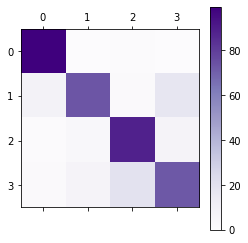

In [ ]:
'''confusion_matrix = [[418.,   0.,   2.,   0.],
        [ 22., 200.,   5.,  46.],
        [  4.,  12., 313.,  23.],
        [  5.,  21.,  62., 233.]]
'''
confusion_matrix = np.array(confusion_matrix)
sum = np.sum(confusion_matrix, axis=1)
sum_array = np.array([[sum[0], sum[0], sum[0], sum[0] ],
                      [sum[1], sum[1], sum[1], sum[1]], 
                      [sum[2], sum[2], sum[2], sum[2]], 
                      [sum[3], sum[3], sum[3], sum[3]]])
confusion_matrix = np.divide(confusion_matrix, sum_array)
confusion_matrix = confusion_matrix * 100
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.Purples):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(confusion_matrix)

In [ ]:
torch.save(model_ft.state_dict(), 'model.pth')


# Test


Test loader

In [ ]:
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = dataloaders_dict['test']
classes = ('normal', 'serrated', 'adenocarcinoma', 'adenoma')

Let’s quickly save our trained model:



In [ ]:
PATH = '/content/drive/MyDrive/chaoyang-data/chaoyang.pth'
torch.save(model_ft.state_dict(), PATH)

We have trained the network for passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

Final Thoughts and Where to Go Next
-----------------------------------

Try running some of the other models and see how good the accuracy gets.
Also, notice that feature extracting takes less time because in the
backward pass we do not have to calculate most of the gradients. There
are many places to go from here. You could:

-  Run this code with a harder dataset and see some more benefits of
   transfer learning
-  Using the methods described here, use transfer learning to update a
   different model, perhaps in a new domain (i.e. NLP, audio, etc.)
-  Once you are happy with a model, you can export it as an ONNX model,
   or trace it using the hybrid frontend for more speed and optimization
   opportunities.


